# **Goal**

Given a dataset containing information about person clean the data and find the best predictor.


# Cleaning the data


---


## Handling Imbalance

As shown below the dataset is not balanced. So I used oversampling and undersampling to artificially make it balanced. But after running a classifier on validation set it performed worse with those techniques. So I just used avg f1 score as model's evaluation tool.

Proportion: 3.15 : 1


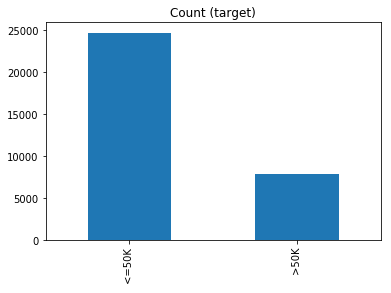

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def plot_classes(df):
	target_count = df['salary'].value_counts()
	print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

	target_count.plot(kind='bar', title='Count (target)')
	plt.show()


df = pd.read_csv('/census.csv')
plot_classes(df)

## Shuffling

Since the dataset is not ordered in any way I don't use shuffling to avoid additional computation time.

## Scaling

I used different scaling techniques like Standart scaler,MaxAbs scaler, MinMax scaler but none contributed to final score.

## Handling categorical features

In order to deal with categorical features I first used one hot encoding and it produced a sparse 
 matrix with 119 columns of zeros and ones. The classifier was not able to generalize and showed signs of overfitting (e.g 0.95 recall on training set and 0.58 recall on validation set). I used PCA to reduce the number of columns to 80/60/40 but it had negative effect on validation score.
 
 ### Combining features
 
 So instead I combined features together and dropped irrelevant ones as shown below.

In [33]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def preprocess_data(df):
    # drop nulls
	for col in df.columns:
		df.drop(df.loc[df[col] == ' ?'].index, inplace=True)

	# salary
	df['salary'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)

	# sex
	df['sex'].replace({' Male': 0, ' Female': 1}, inplace=True)

	# country
	mean_by_country = df[['native-country', 'salary']].groupby(['native-country']).mean().mean()['salary']
	grouped_countries = df[['native-country', 'salary']].groupby(['native-country'], as_index=False).mean()
    
    # divide contries into 2 categories depending on whether they provide a higher salary than mean salary which is ~0.2
	rich_countries = grouped_countries.loc[grouped_countries['salary'] > mean_by_country, 'native-country'].unique()
	poor_countries = list(set(grouped_countries['native-country']) - set(rich_countries))

	df['native-country'].replace(poor_countries, 0, inplace=True)
	df['native-country'].replace(rich_countries, 1, inplace=True)
    
    # marital status
    # divide people as being married or not since they have different mean income levels
	not_married = [' Divorced', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed']
	married = [' Married-AF-spouse', ' Married-civ-spouse']

	df['marital-status'].replace(not_married, 0, inplace=True)
	df['marital-status'].replace(married, 1, inplace=True)

	# race
    # each race has different level of mean income
	races = {' White': 0, ' Amer-Indian-Eskimo': 1, ' Asian-Pac-Islander': 2, ' Black': 3, ' Other': 4}
	df['race'].replace(races, inplace=True)

	# occupation
    # divide the same way as countries
	mean_by_occupation = df[['occupation', 'salary']].groupby(['occupation']).mean().mean()['salary']
	grouped_occupations = df[['occupation', 'salary']].groupby(['occupation'], as_index=False).mean()

	rich_occupations = grouped_occupations.loc[
		grouped_occupations['salary'] > mean_by_occupation, 'occupation'].unique()
	poor_occupations = list(set(grouped_occupations['occupation']) - set(rich_occupations))

	df['occupation'].replace(poor_occupations, 0, inplace=True)
	df['occupation'].replace(rich_occupations, 1, inplace=True)

	# education
    # divide the same way as marital status
	no_college = [' Preschool', ' 1st-4th', ' 5th-6th', ' 9th', ' 11th', ' 7th-8th', ' 10th', ' 12th', ' HS-grad']
	college = [' Some-college', ' Assoc-acdm', ' Assoc-voc']
	university = [' Bachelors', ' Masters', ' Doctorate', ' Prof-school']

	df['education'].replace(no_college, 0, inplace=True)
	df['education'].replace(college, 1, inplace=True)
	df['education'].replace(university, 2, inplace=True)

	# relationship
    # divide people as being wife or husband since the latter have higher mean income level
	not_wife_husband = [' Own-child', ' Other-relative', ' Unmarried', ' Not-in-family']
	wife_husband = [' Husband', ' Wife']

	df['relationship'].replace(not_wife_husband, 0, inplace=True)
	df['relationship'].replace(wife_husband, 1, inplace=True)

	# drops
    # drop columns that are duplicate or don't have impact on final classification 
	df.drop(columns=['education-num', 'fnlwgt', 'city', 'workclass'], inplace=True)
	
	print_df(df.head())

    
def print_df(df):
	with pd.option_context('display.max_rows', None, 'display.max_columns', None):
		print(df)
    
df = pd.read_csv('/census.csv')
preprocess_data(df)

   age  education  marital-status  occupation  years_of_experience  \
0   39          2               0           0                    4   
1   50          2               1           1                   14   
2   38          0               0           0                    4   
3   53          0               1           0                   14   
4   28          2               1           1                   11   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             0     0    0          2174             0              40   
1             1     0    0             0             0              13   
2             0     0    0             0             0              40   
3             1     3    0             0             0              40   
4             1     3    1             0             0              40   

   native-country  salary  
0               1       0  
1               1       0  
2               1       0  
3               1     

# Finding a classifier

To find the best classifier I used [sklearn's cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). I chose Random forest classifier as it performed the best with avg f1 score. I used Voting classifier from sklearn but id did not improve accuracy. Also I provided grid search to find the best hyperparameters of Random forest but it was taking too long on my laptop without GPU so I interrupted it.


# Full Code

In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def preprocess_data(df):
	# drop nulls
	for col in df.columns:
		df.drop(df.loc[df[col] == ' ?'].index, inplace=True)

	# salary
	df['salary'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)

	# sex
	df['sex'].replace({' Male': 0, ' Female': 1}, inplace=True)

	# country
	mean_by_country = df[['native-country', 'salary']].groupby(['native-country']).mean().mean()['salary']
	grouped_countries = df[['native-country', 'salary']].groupby(['native-country'], as_index=False).mean()

	rich_countries = grouped_countries.loc[grouped_countries['salary'] > mean_by_country, 'native-country'].unique()
	poor_countries = list(set(grouped_countries['native-country']) - set(rich_countries))

	df['native-country'].replace(poor_countries, 0, inplace=True)
	df['native-country'].replace(rich_countries, 1, inplace=True)

	# marital status
	not_married = [' Divorced', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed']
	married = [' Married-AF-spouse', ' Married-civ-spouse']

	df['marital-status'].replace(not_married, 0, inplace=True)
	df['marital-status'].replace(married, 1, inplace=True)

	# race
	races = {' White': 0, ' Amer-Indian-Eskimo': 1, ' Asian-Pac-Islander': 2, ' Black': 3, ' Other': 4}
	df['race'].replace(races, inplace=True)

	# occupation
	mean_by_occupation = df[['occupation', 'salary']].groupby(['occupation']).mean().mean()['salary']
	grouped_occupations = df[['occupation', 'salary']].groupby(['occupation'], as_index=False).mean()

	rich_occupations = grouped_occupations.loc[
		grouped_occupations['salary'] > mean_by_occupation, 'occupation'].unique()
	poor_occupations = list(set(grouped_occupations['occupation']) - set(rich_occupations))

	df['occupation'].replace(poor_occupations, 0, inplace=True)
	df['occupation'].replace(rich_occupations, 1, inplace=True)

	# education
	no_college = [' Preschool', ' 1st-4th', ' 5th-6th', ' 9th', ' 11th', ' 7th-8th', ' 10th', ' 12th', ' HS-grad']
	college = [' Some-college', ' Assoc-acdm', ' Assoc-voc']
	university = [' Bachelors', ' Masters', ' Doctorate', ' Prof-school']

	df['education'].replace(no_college, 0, inplace=True)
	df['education'].replace(college, 1, inplace=True)
	df['education'].replace(university, 2, inplace=True)

	# relationship
	not_wife_husband = [' Own-child', ' Other-relative', ' Unmarried', ' Not-in-family']
	wife_husband = [' Husband', ' Wife']

	df['relationship'].replace(not_wife_husband, 0, inplace=True)
	df['relationship'].replace(wife_husband, 1, inplace=True)

	# drops
	df.drop(columns=['education-num', 'fnlwgt', 'city', 'workclass'], inplace=True)

	# split
	features = df.columns[:-1]
	xs = df[features].values
	ys = df['salary'].values

	x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.1, shuffle=False)

	x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

	return x_train, x_test, y_train, y_test, x_val, y_val


def fit(x_train, y_train):
	clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=25)
	clf.fit(x_train, y_train)
	return clf


def validate(clf, x_train, y_train, x_val, y_val):
	print('Train Results')
	prediction_train = clf.predict(x_train)
	print(classification_report(y_train, prediction_train))

	print()

	print('Validation Results')
	prediction_val = clf.predict(x_val)
	print(classification_report(y_val, prediction_val))


def test(clf, x_test, y_test):
	print('Test Results')
	prediction = clf.predict(x_test)
	print(classification_report(y_test, prediction))


def main():
	workers_df = pd.read_csv('/census.csv')
	x_train, x_test, y_train, y_test, x_val, y_val = preprocess_data(workers_df)

	clf = fit(x_train, y_train)

	test(clf, x_test, y_test)


main()


Test Results
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2248
           1       0.75      0.61      0.67       769

    accuracy                           0.85      3017
   macro avg       0.81      0.77      0.79      3017
weighted avg       0.84      0.85      0.84      3017

